<a href="https://colab.research.google.com/github/darkmetrics/CarryTrade/blob/main/carry_trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/darkmetrics/CarryTrade/blob/main/carry_trade.ipynb)

### 1. Предобработка данных.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union

Загрузим данные и посмотрим на них.

In [ ]:
fx = pd.read_excel('data/clean_data.xlsx', sheet_name='fx')
vol = pd.read_excel('data/clean_data.xlsx', sheet_name='volatility')
print('\n Первые 5 строк набора данных для валют: \n')
fx.head()
fx.info()
print('\n Первые 5 строк набора данных для волатильности: \n')
vol.head()
vol.info()


 Первые 5 строк набора данных для валют: 



,date,EUR_bid,EUR_mid,EUR_ask,EUR_fwd_bid,EUR_fwd_mid,EUR_fwd_ask,AUD_bid,AUD_mid,AUD_ask,...,NZD_ask,NZD_fwd_bid,NZD_fwd_mid,NZD_fwd_ask,SEK_bid,SEK_mid,SEK_ask,SEK_fwd_bid,SEK_fwd_mid,SEK_fwd_ask
0,1996-12-31,1.5385,1.53870,1.5389,-31.20,-31.20,-31.20,0.7940,0.79415,0.7943,...,0.7071,-13.75,-13.75,-13.75,6.8072,6.81220,6.8172,-89.5,-89.5,-89.5
1,1997-01-01,1.5388,1.53905,1.5393,-31.50,-31.50,-31.50,0.7943,0.79455,0.7948,...,0.7062,-13.50,-13.50,-13.50,6.8036,6.80735,6.8111,-87.5,-87.5,-87.5
2,1997-01-02,1.5415,1.54175,1.5420,-31.50,-31.50,-31.50,0.7908,0.79105,0.7913,...,0.7079,-13.75,-13.75,-13.75,6.8701,6.87510,6.8801,-8.0,-8.0,-8.0
3,1997-01-03,1.5672,1.56745,1.5677,-30.95,-30.95,-30.95,0.7901,0.79045,0.7908,...,0.7072,-14.00,-14.00,-14.00,6.9583,6.96205,6.9658,-93.0,-93.0,-93.0
4,1997-01-06,1.5656,1.56585,1.5661,-32.25,-32.25,-32.25,0.7891,0.78935,0.7896,...,0.7095,-12.75,-12.75,-12.75,6.9416,6.94660,6.9516,-93.5,-93.5,-93.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 55 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4545 non-null   datetime64[ns]
 1   EUR_bid      4545 non-null   float64       
 2   EUR_mid      4545 non-null   float64       
 3   EUR_ask      4545 non-null   float64       
 4   EUR_fwd_bid  4533 non-null   float64       
 5   EUR_fwd_mid  4544 non-null   float64       
 6   EUR_fwd_ask  4537 non-null   float64       
 7   AUD_bid      4545 non-null   float64       
 8   AUD_mid      4545 non-null   float64       
 9   AUD_ask      4545 non-null   float64       
 10  AUD_fwd_bid  4539 non-null   float64       
 11  AUD_fwd_mid  4544 non-null   float64       
 12  AUD_fwd_ask  4530 non-null   float64       
 13  CAD_bid      4545 non-null   float64       
 14  CAD_mid      4545 non-null   float64       
 15  CAD_ask      4545 non-null   float64       
 16  CAD_fw

,date,VIX,VXY
0,1990-01-02,17.24,NaN
1,1990-01-03,18.19,NaN
2,1990-01-04,19.22,NaN
3,1990-01-05,20.11,NaN
4,1990-01-08,20.26,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6150 entries, 0 to 6149
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6150 non-null   datetime64[ns]
 1   VIX     6150 non-null   float64       
 2   VXY     5535 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 144.3 KB


Мы видим, что в наборе данных есть пропуски для некоторых валютных пар (например, SEK или NZD), и пропусков этих немного - спасибо Блумбергу! В то же время, для индекса волатильности VXY нет данных за несколько лет, и тут мы ничего заполнять не будем. Заполним пропуски для валют и форвардов:

In [ ]:
fx.fillna(method='ffill', inplace=True)

Поменяем для обоих наборов данных индексы: сделаем индексом дату.

In [ ]:
fx.index = pd.to_datetime(fx.date)
vol.index = pd.to_datetime(vol.date)
fx.drop(columns='date', inplace=True)
vol.drop(columns='date', inplace=True)

Теперь 
1. Отберем пока только цену `mid` для спотовых и форвардных котировок, так как все остальное нужно нам только для расчета транзакционных издержек, а они невелики и на начальном этапе ими можно пренебречь без существенного искажения результатов. 
2. Переименуем столбцы, чтобы с ними удобнее было работать: форварды назовем "Имя валюты"+"1m".

In [ ]:
mid_cols = [x for x in fx.columns if 'mid' in x]
fx = fx[mid_cols]
new_colnames = [x.replace('_fwd_mid', '1m') if '_fwd_mid' in x \
                else x.replace('_mid', '') for x in fx.columns]
fx.columns = new_colnames
fx.head(5)

,EUR,EUR1m,AUD,AUD1m,CAD,CAD1m,CHF,CHF1m,GBP,GBP1m,JPY,JPY1m,NOK,NOK1m,NZD,NZD1m,SEK,SEK1m
date,,,,,,,,,,,,,,,,,,
1996-12-31,1.53870,-31.20,0.79415,-3.827,1.37050,-29.739,1.34150,-42.396,1.71400,-11.0,115.700,-49.812,6.37745,-98.0,0.70675,-13.75,6.81220,-89.5
1997-01-01,1.53905,-31.50,0.79455,-3.300,1.37045,-27.750,1.34125,-43.000,1.71150,-10.5,115.885,-51.000,6.37765,-98.0,0.70595,-13.50,6.80735,-87.5
1997-01-02,1.54175,-31.50,0.79105,-3.600,1.37595,-28.376,1.34845,-42.616,1.69390,-10.5,115.675,-50.500,6.38175,-95.0,0.70765,-13.75,6.87510,-8.0
1997-01-03,1.56745,-30.95,0.79045,-3.386,1.37025,-27.249,1.35950,-42.555,1.68730,-10.6,116.435,-50.500,6.48370,-102.0,0.70685,-14.00,6.96205,-93.0
1997-01-06,1.56585,-32.25,0.78935,-3.654,1.36555,-27.704,1.35300,-44.637,1.69635,-11.5,115.745,-51.000,6.46555,-115.0,0.70915,-12.75,6.94660,-93.5


3. Теперь пересчитаем форвардную котировку в более удобном виде. Для этого для всех валют, кроме йены, поделим цену форварда на 10 000 (для йены - на 100) и добавим к этому значению спотовую цену валюты.

In [ ]:
spot_no_jpy = [x for x in fx.columns if '1m' not in x and 'JPY' not in x]
for ticker in spot_no_jpy:
    fx[f"{ticker}1m"]=fx[ticker]+fx[f"{ticker}1m"]/10_000
fx['JPY1m']=fx['JPY']+fx['JPY1m']/100
fx.head(5)

,EUR,EUR1m,AUD,AUD1m,CAD,CAD1m,CHF,CHF1m,GBP,GBP1m,JPY,JPY1m,NOK,NOK1m,NZD,NZD1m,SEK,SEK1m
date,,,,,,,,,,,,,,,,,,
1996-12-31,1.53870,1.535580,0.79415,0.793767,1.37050,1.367526,1.34150,1.337260,1.71400,1.71290,115.700,115.20188,6.37745,6.36765,0.70675,0.705375,6.81220,6.80325
1997-01-01,1.53905,1.535900,0.79455,0.794220,1.37045,1.367675,1.34125,1.336950,1.71150,1.71045,115.885,115.37500,6.37765,6.36785,0.70595,0.704600,6.80735,6.79860
1997-01-02,1.54175,1.538600,0.79105,0.790690,1.37595,1.373112,1.34845,1.344188,1.69390,1.69285,115.675,115.17000,6.38175,6.37225,0.70765,0.706275,6.87510,6.87430
1997-01-03,1.56745,1.564355,0.79045,0.790111,1.37025,1.367525,1.35950,1.355244,1.68730,1.68624,116.435,115.93000,6.48370,6.47350,0.70685,0.705450,6.96205,6.95275
1997-01-06,1.56585,1.562625,0.78935,0.788985,1.36555,1.362780,1.35300,1.348536,1.69635,1.69520,115.745,115.23500,6.46555,6.45405,0.70915,0.707875,6.94660,6.93725


4. Наконец, приведем все котировки спот и форвард к единому формату: 1 USD per 1 currency unit. Для этого возведем в -1 степень некоторые столбцы:
* EUR
* AUD
* GBP
* NZD

In [ ]:
invert = [x for x in fx.columns if \
          any(y in x for y in['EUR', 'AUD', 'GBP', 'NZD'])]
invert
for x in invert:
    fx[x] = 1/fx[x]

['EUR', 'EUR1m', 'AUD', 'AUD1m', 'GBP', 'GBP1m', 'NZD', 'NZD1m']

Нарисуем два графика: один для спота, другой для форвардов.

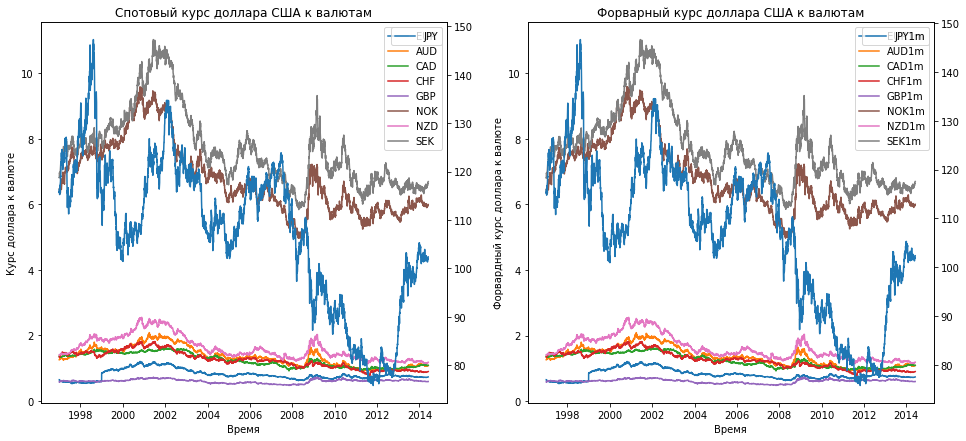

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

ax2 = ax[0].twinx()
for ticker in spot_no_jpy:
    ax[0].plot(fx.index, fx[ticker], label=ticker)
ax2.plot(fx.index, fx.JPY, label='JPY')
ax[0].legend()
ax2.legend()
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Курс доллара к валюте')
ax[0].set_title('Спотовый курс доллара США к валютам')

ax3 = ax[1].twinx()
for ticker in [x+'1m' for x in spot_no_jpy]:
    ax[1].plot(fx.index, fx[ticker], label=ticker)
ax3.plot(fx.index, fx.JPY1m, label='JPY1m')
ax[1].legend()
ax3.legend()
ax[1].set_xlabel('Время')
ax[1].set_ylabel('Форвардный курс доллара к валюте')
ax[1].set_title('Форварный курс доллара США к валютам')

fig.show();

Поскольку эти графики не слишком информативны, нарисуем форвардную премию в процентах для каждой из валют в выборке:

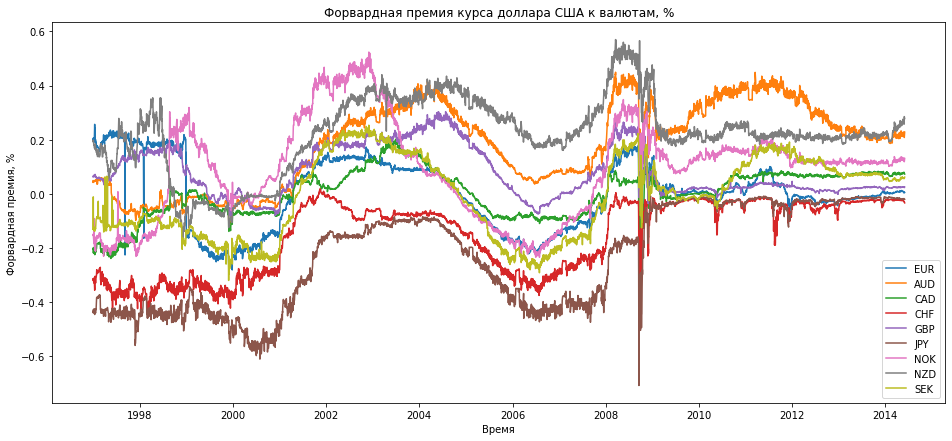

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))

for ticker in [x for x in fx.columns if '1m' not in x]:
    ax.plot(fx.index, 
               (fx[f"{ticker}1m"]-fx[ticker])/fx[ticker]*100, 
               label=ticker)
ax.legend()
ax.set_xlabel('Время')
ax.set_ylabel('Форвардная премия, %')
ax.set_title('Форвардная премия курса доллара США к валютам, %')
fig.show();

Вот это уже информативней. Мы видим, что австралийский доллар (оранжевый) и новозеландский доллар (серый) в основном торговались с форвардной премией, а  йена и франк (коричневый и красный) - с дисконтом. Это совпадает с тем, что пишут авторы, и в принципе логично - Япония с начала нулевых проводила политику ZIRP, поэтому японские ставки были ниже американских, а значит, форвардный курс JPYUSD должен был закладывать ослабление доллара против йены.

Также можно заметить, что после кризиса 2008 года в рамках мягкой денежно-кредитной политики произошло снижение ставок во всех странах G10 - это четко видно на графике по снижению форвардных премий и дисконтов.

Теперь нарисуем данные по индексам волатильности:

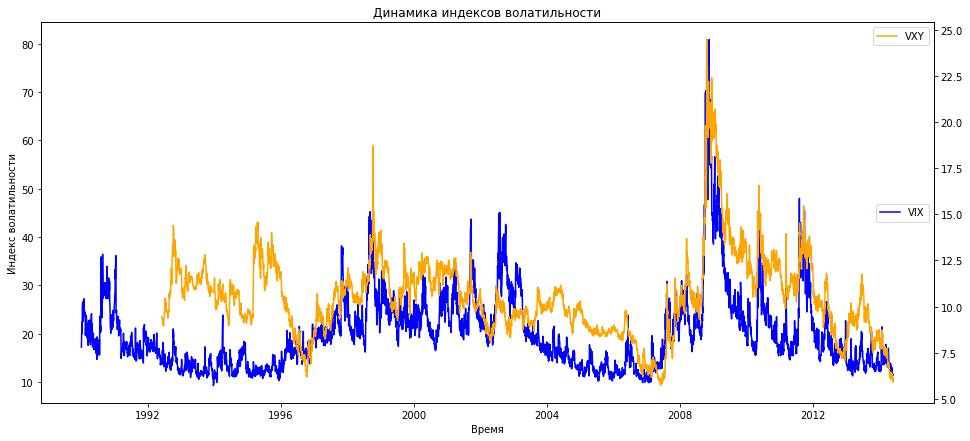

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))

ax2 = ax.twinx()
ax.plot(vol.index, vol.VIX, label='VIX', color='blue')
ax2.plot(vol.index, vol.VXY, label='VXY', color='orange')
ax.legend(loc='center right')
ax2.legend()
ax.set_xlabel('Время')
ax.set_ylabel('Индекс волатильности')
ax.set_title('Динамика индексов волатильности')
fig.show();

Нарисуем совместное распределение индексов волатильности.

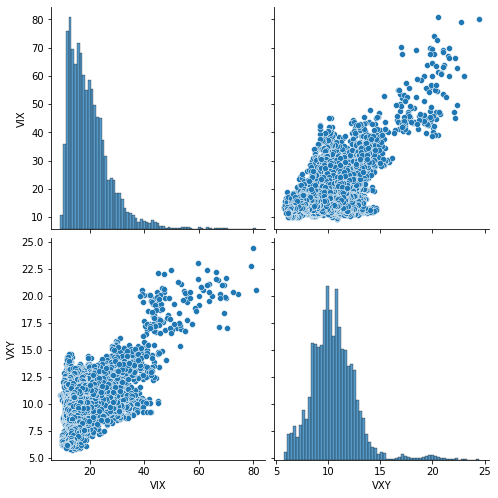

In [ ]:
sns.pairplot(vol, height=3.5);

С предобработкой данных закончено, можно сохранять датасет.

In [ ]:
fx.to_csv('data/fx.csv')
vol.to_csv('data/vol.csv')

### 2. Стратегия Carry Trade.
Напишем функцию, которая будет гонять стратегию кэрри трейд.

In [3]:
print('Hello!')

Hello!


In [4]:
fx_url = 'https://raw.githubusercontent.com/darkmetrics/CarryTrade/main/data/fx.csv'
vol_url = 'https://raw.githubusercontent.com/darkmetrics/CarryTrade/main/data/vol.csv'
fx = pd.read_csv(fx_url, parse_dates=True, index_col='date')
vol = pd.read_csv(vol_url, parse_dates=True, index_col='date')

In [5]:
fx.head()

,EUR,EUR1m,AUD,AUD1m,CAD,CAD1m,CHF,CHF1m,GBP,GBP1m,JPY,JPY1m,NOK,NOK1m,NZD,NZD1m,SEK,SEK1m
date,,,,,,,,,,,,,,,,,,
1996-12-31,0.649899,0.651220,1.259208,1.259815,1.37050,1.367526,1.34150,1.337260,0.583431,0.583805,115.700,115.20188,6.37745,6.36765,1.414927,1.417686,6.81220,6.80325
1997-01-01,0.649751,0.651084,1.258574,1.259097,1.37045,1.367675,1.34125,1.336950,0.584283,0.584641,115.885,115.37500,6.37765,6.36785,1.416531,1.419245,6.80735,6.79860
1997-01-02,0.648614,0.649942,1.264143,1.264718,1.37595,1.373112,1.34845,1.344188,0.590354,0.590720,115.675,115.17000,6.38175,6.37225,1.413128,1.415879,6.87510,6.87430
1997-01-03,0.637979,0.639241,1.265102,1.265644,1.37025,1.367525,1.35950,1.355244,0.592663,0.593035,116.435,115.93000,6.48370,6.47350,1.414727,1.417535,6.96205,6.95275
1997-01-06,0.638631,0.639949,1.266865,1.267452,1.36555,1.362780,1.35300,1.348536,0.589501,0.589901,115.745,115.23500,6.46555,6.45405,1.410139,1.412679,6.94660,6.93725


При расчете квантиля распределения индекса волатильности я выставил метод `nearest`, то есть не делается никакой интерполяции, а просто ищется ближайшее к квантилю значение в выборке. Возможно, этот параметр надо покрутить, но при достаточно большом количестве наблюдений в выборке я не думаю, что способ расчета квантиля способен повлиять на получившееся значения квантиля выборочного распределения.

In [6]:
class CarryTrade:
    def __init__(self, 
                 fx:pd.DataFrame, 
                 vol:Union[pd.Series, None]=None):
        """
        Class constructor. 
        
        Parameters:
        -----------
        fx: pd.DataFrame with spot and forward FX prices. Forward FX
            columns should contain '1m' in column names. For each currency
            in the dataset there should be both spot and forward column.
            Number of currencies can not be less than n_trade * 2.
        vol: pd.Series, default None. pd.Series with historical values
            for some volatility index.
        """
        self.fx = fx
        # it's important to drop na because np.percentile treats na as infty
        if vol is not None:
            self.vol = vol.dropna()
        # empty attributes for future data
        self.vol_data = None
        self.carry_returns = None
        self.strategy_returns = None
    
    def run(self, 
            n_trade:int=3,
            use_vol:bool=False,
            vol_type:str='simple',
            vol_quantile:float=0.95,
            quantile_method:str='nearest',
            vol_lag:int=1,
            refit:bool=True):
        """
        Method to run strategy on data from self.fx and self.vol
        
        Parameters:
        -----------
        n_trade:int, default 3 (as in article). Number of currency pairs
            to long and to short.    
        use_vol: bool, default False. Whether to use volatility data when
            running strategy or not.
        vol_type: str, default 'simple'. Possible values: 'simple' or 
            'averaged'. Depends on the volatility signal methodology 
            calculation (simple or averaged by 60 days, for details study
            the paper).
        vol_quantile:float, default None. The percentile of empirical
            volatility indicator distribution to use when calculating 
            "signal" for trading strategy (whether to trade or not).
        quantile_method: str, default 'nearest'. Possible values: 'linear', 
            'lower', 'higher', 'midpoint', 'nearest'. Empirical quantile 
            calculation method for np.percentile for volatility index.
        vol_lag: int, default 1. How many periods to shift volatility indicator
            ahead to use lags of volatility when calculating "signal".
        refit: bool, default True. Whether to run not only volatility estimation
        and carry trade with volatility, but also simple carry strategy when 
        simple carry trade has already been estimated before (attribute 
        carry_returns is not empty).
        """
        
        # names for forward, spot and forward premium columns
        spot_cols = [x for x in self.fx.columns if '1m' not in x]
        fwd_cols = [x for x in self.fx.columns if '1m' in x]
        prem_cols = [x+'_premium' for x in spot_cols]
        ret_cols = [x+'_ret' for x in spot_cols]
        pos_cols = [x+'_pos' for x in spot_cols]
        
        if refit:
            # calculate spot returns and forward premiums 
            for x in spot_cols:
                self.fx[f'{x}_ret']=self.fx[x].pct_change()
                self.fx[f'{x}_premium']=(self.fx[f'{x}1m'] - self.fx[x])/self.fx[x]
                
        
            # shift premium column data 1 day ahead
            # to use forward data from day t_1 to trade in day t
            self.fx[prem_cols].shift(1)
            self.fx.dropna(inplace=True)
            
            # transform data to dict to make strategy faster
            fx_dict = self.fx[prem_cols].to_dict(orient='index')
            position_dict = {}
            
            # find tickers with n_trade highest forward premiums
            # and n_trade lowest forward premiums for each date
            for time, data in fx_dict.items():
                sorted_data = {k: v for k, v in \
                               sorted(data.items(), key=lambda item:item[1])}
                
                sorted_tickers = list(sorted_data.keys())
                # short tickers with highest premium (lowest discount)
                short_tickers = [x.split('_')[0] for x in sorted_tickers[-n_trade:]]
                # long tickers with lowest premium (highest discount)
                long_tickers = [x.split('_')[0] for x in sorted_tickers[0:n_trade]]
    
                # add positions to position dict
                position_dict[time]={(k+"_pos"):1 if k in long_tickers else \
                                     (-1 if k in short_tickers else 0) \
                                     for k in spot_cols}
        
            position_df = pd.DataFrame(position_dict).T
            self.fx = pd.merge(left=position_df, right=self.fx, 
                               left_index=True,
                               right_index=True)
            # calculate total strategy returns
            self.fx['carry_returns']=( (self.fx[pos_cols].div(n_trade)).values * \
                                         (self.fx[ret_cols]).values ).sum(axis=1)
            self.carry_returns = self.fx['carry_returns']
        
        # take into account volatility
        if use_vol:
            if vol_type=='simple':
                # calculate volatility percentiles and threshold
                self.simple_vol(vol_quantile, quantile_method, vol_lag)
            elif vol_type=='averaged':
                # calculate volatility percentiles and threshold
                self.averaged_vol(self, vol_quantile, quantile_method, vol_lag)
                
            self.fx['strategy_returns'] = self.fx['carry_returns'] * \
                                         self.vol_data['signal']
            self.fx.dropna(inplace=True)
            self.strategy_returns = self.fx['strategy_returns']
            
    
    def simple_vol(self,
                   vol_quantile:float=0.95,
                   quantile_method:str='nearest',
                   vol_lag:int=1):
        """
        Estimate simple rolling volatility percentile
        """
        # get volatility index name
        vol_index = self.vol.name
        # calculate expanding window volatility percentile
        percentile = self.vol.expanding().apply(lambda x: \
                                     np.quantile(x, 
                                                 q=vol_quantile, 
                                                 interpolation=quantile_method))
        percentile.name='threshold'
        # shift (or not shift) volatility data to decide whether 
        # to trade or not in day t based on volatility data from t-1
        self.vol_data = pd.concat([self.vol.shift(vol_lag), 
                                   percentile.shift(vol_lag)], 
                                   axis=1)
        
        # add missing dates to self.vol_data from self.fx
        new_index = self.fx.index
        self.vol_data = self.vol_data.reindex(new_index, method='ffill')
        # drop unnecessary dates from 1990 to 1996
        self.vol_data = self.vol_data.loc[new_index]
        # calculate trading signal
        self.vol_data['signal'] = (self.vol_data[vol_index]<=\
                                   self.vol_data['threshold'])*1
        
        
    def averaged_vol(self,        
                     vol_quantile:float=0.95,
                     quantile_method:str='nearest',
                     vol_lag:int=1):
        """
        Returns volatility percentile as volatility index change 
        divided by average 60-day volatility levels
        """
        # get volatility index name
        vol_index = self.vol.name
        # calculate expanding window average VIX over last 60 days
        average_60 = self.vol.rolling(window=60).mean().shift(1)
        # we shift series by 1 since volatility in day t is divided by
        # average of t-1 ... t-60 volatility values
        vol_change = self.vol/average_60
        percentile = vol_change.expanding().apply(lambda x: \
                                     np.quantile(x, 
                                                 q=vol_quantile, 
                                                 interpolation=quantile_method))
        vol_change.name = f'{vol_index}_change'
        percentile.name='threshold'
        # shift (or not shift) volatility data to decide whether 
        # to trade or not in day t based on volatility data from t-1
        self.vol_data = pd.concat([vol_change.shift(vol_lag),
                                   percentile.shift(vol_lag)], 
                                   axis=1)
        # add missing dates to self.vol_data from self.fx
        new_index = self.fx.index
        self.vol_data = self.vol_data.reindex(new_index, method='ffill')
        # drop unnecessary dates from 1990 to 1996
        self.vol_data = self.vol_data.loc[new_index]
        # calculate trading signal
        self.vol_data['signal'] = (self.vol_data[vol_change.name]<=\
                                   self.vol_data['threshold'])*1
        
    def your_vol_method(self):
        """ Define your volatility calculation method here """
        pass
    
    
    def perf_metrics(self):
        """ Returns performance metrics for the strategy """
        carry_return = ((self.carry_returns + 1).cumprod() - 1).values[-1]
        strategy_return = ((self.strategy_returns + 1).cumprod() - 1).values[-1]
        # annualized return as (mean daily return + 1)^250 - 1
        carry_annualized = (self.carry_returns.mean() + 1)**250 - 1
        strategy_annualized = (self.strategy_returns.mean() + 1)**250 - 1
        carry_sharpe = self.carry_returns.mean()/self.carry_returns.std()
        strategy_sharpe = self.strategy_returns.mean()/self.strategy_returns.std()
        
        return {'Carry trade total return': carry_return,
                'Strategy total return': strategy_return,
                'Carry trade annualized total return': carry_annualized,
                'Strategy annualized total return': strategy_annualized,
                'Carry trade Sharpe ratio':carry_sharpe,
                'Strategy Sharpe ratio': strategy_sharpe}
        

В качестве примера, создадим и прогоним простую стратегию кэрри трэйд безо всяких волатильностей.

Для этого передадим в конструктор класса `CarryTrade` аргумент `fx` (набор цен спотовых и форвардных валютных пар). Аргумент `vol` (исторические данные по волатильности) в нашем случае передавать не надо, так как волатильность мы не учитываем, и по умолчанию он равен `None`.

Посмотрим на то, сохранились ли нормально внутри экземпляра класса данные - напечатаем их.

In [7]:
SimpleCarry = CarryTrade(fx=fx.copy())
SimpleCarry.fx.head(5)

,EUR,EUR1m,AUD,AUD1m,CAD,CAD1m,CHF,CHF1m,GBP,GBP1m,JPY,JPY1m,NOK,NOK1m,NZD,NZD1m,SEK,SEK1m
date,,,,,,,,,,,,,,,,,,
1996-12-31,0.649899,0.651220,1.259208,1.259815,1.37050,1.367526,1.34150,1.337260,0.583431,0.583805,115.700,115.20188,6.37745,6.36765,1.414927,1.417686,6.81220,6.80325
1997-01-01,0.649751,0.651084,1.258574,1.259097,1.37045,1.367675,1.34125,1.336950,0.584283,0.584641,115.885,115.37500,6.37765,6.36785,1.416531,1.419245,6.80735,6.79860
1997-01-02,0.648614,0.649942,1.264143,1.264718,1.37595,1.373112,1.34845,1.344188,0.590354,0.590720,115.675,115.17000,6.38175,6.37225,1.413128,1.415879,6.87510,6.87430
1997-01-03,0.637979,0.639241,1.265102,1.265644,1.37025,1.367525,1.35950,1.355244,0.592663,0.593035,116.435,115.93000,6.48370,6.47350,1.414727,1.417535,6.96205,6.95275
1997-01-06,0.638631,0.639949,1.266865,1.267452,1.36555,1.362780,1.35300,1.348536,0.589501,0.589901,115.745,115.23500,6.46555,6.45405,1.410139,1.412679,6.94660,6.93725


Запустим стратегию. Поскольку, опять же, волатильность мы не учитываем, и по умолчанию `use_vol=False`, то единственный аргумент, который нам надо передать методу `run` (этот метод гоняет стратегию на реальных данных) - это `n_trade`, число валютных пар, которые мы покупаем в лонг и в шорт (всего 3 в лонг и 3 в шорт).

In [8]:
%%time
SimpleCarry.run(n_trade=3)

CPU times: user 539 ms, sys: 12.4 ms, total: 552 ms
Wall time: 567 ms


Посмотрим на содержимое нашей стратегии: скажем, посчитаем кумулятивные доходности кэрри трейда и отрисуем их на графике вместе с индексами волатильности, как оно и делалось в статье.

In [9]:
# доходности carry trade
SimpleCarry.carry_returns

1997-01-01   -0.000330
1997-01-02    0.000444
1997-01-03    0.007325
1997-01-06   -0.002194
1997-01-07   -0.003752
                ...   
2014-05-27    0.002783
2014-05-28   -0.003463
2014-05-29    0.001962
2014-05-30   -0.001551
2014-06-02   -0.001154
Name: carry_returns, Length: 4544, dtype: float64

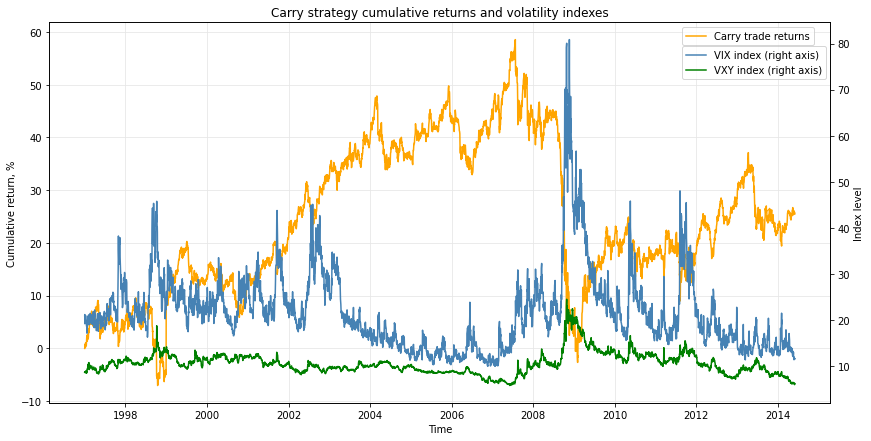

In [10]:
carry_cumrets = (SimpleCarry.carry_returns+1).cumprod()
new_vol = vol.copy()
new_vol = new_vol.reindex(carry_cumrets.index, method='ffill')
new_vol = new_vol.loc[carry_cumrets.index]

fig, ax = plt.subplots(figsize=(14, 7))
ax2 = ax.twinx()
ax.plot(carry_cumrets.index, carry_cumrets.values*100 -100, 
        color='orange', label='Carry trade returns')
ax2.plot(new_vol.index, new_vol.VIX, color='steelblue', label='VIX index (right axis)')
ax2.plot(new_vol.index, new_vol.VXY, color='green', label='VXY index (right axis)')
ax.legend(loc=(0.81, 0.94))
ax2.legend(loc=(0.81, 0.85))
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative return, %')
ax2.set_ylabel('Index level')
ax.grid(color='0.9')
ax.set_title('Carry strategy cumulative returns and volatility indexes')
fig.show();

### 3. Стратегия Carry Trade с учетом волатильности.

Напомню, что в рамках статьи при использовании VIX как индикатора волатильности при первом подходе к снаряду (когда индекс волатильности не усредняется) решение о том, совершать сделку или нет, принимается на основе $Signal_t$:

$$
Strategy\ return_t = Signal_t \times Carry\ Trade\ Return_t \\
Signal_t = \begin{cases} 
                  1, & \mbox{if }\ VIX_{t-1} \leq\ threshold_{t-1}\\ 
                  0, & \mbox{if }\ VIX_{t-1} >\ threshold_{t-1}
           \end{cases}
$$

Запустим стратегию для примера на индексе VIX, отбросив 2.5% самых больших значений эмпирического распределения VIX (если индекс попадает в этот перцентиль, мы не торгуем).

Снова создадим экземпляр класса `CarryTrade`, теперь передадим туда уже данные не только по валютам, но и по волатильности. Далее для этого экземпляра запустим метод `run`, передав в него аргументы для расчета волатильности нужным способом:
* `use_vol` - это просто что мы используем данные волатильности при торговле.
* `vol_type='simple` - метод расчета сигнала волатильности, в данном случае просто квантиль, безо всяких усреднений.
* `vol_quantile=0.975` - то есть мы не торгуем, если значения индекса волатильности попадают в правый 2.5% квантиль эмпирического распределения индекса.
* `quantile_method='nearest'` - для `np.quantile`, каким методом считать выборочный квантиль (там есть много разных методов, я прописал их в документации к методу `run`).
* `vol_lag=1` - с каким лагом брать данные по волатильности. В данном случае берем данные волатильности из предыдущего дня.

In [ ]:
%%time
VixCarry = CarryTrade(fx=fx.copy(), vol=vol.VIX.copy())
VixCarry.run(n_trade=3, 
             use_vol=True, 
             vol_type='simple',
             vol_quantile=0.975, 
             quantile_method='nearest', 
             vol_lag=1)

CPU times: user 1.19 s, sys: 8.75 ms, total: 1.2 s
Wall time: 1.2 s


В объекте класса теперь хранится куча информации, которую при необходимости можно извлечь:

In [ ]:
# доходности простой стратегии кэрри трейд без учета волатильности
VixCarry.carry_returns
# доходности стратегии кэрри с волатильностью
VixCarry.strategy_returns
# данные о волатильности с выборочными перцентилями и сигналами 
# (свинуты вперед на 1 день)
VixCarry.vol_data
# можно даже вытащить данные о торговых позициях по каждой валюте на каждый день
# для этого нужно к названиям столбцов со спотовыми котировками валюты прибавить '_pos'
position_cols = [x+'_pos' for x in fx.columns if '1m' not in x]
VixCarry.fx[position_cols]

1997-01-01   -0.000330
1997-01-02    0.000444
1997-01-03    0.007325
1997-01-06   -0.002194
1997-01-07   -0.003752
                ...   
2014-05-27    0.002783
2014-05-28   -0.003463
2014-05-29    0.001962
2014-05-30   -0.001551
2014-06-02   -0.001154
Name: carry_returns, Length: 4544, dtype: float64

1997-01-01   -0.000330
1997-01-02    0.000444
1997-01-03    0.007325
1997-01-06   -0.002194
1997-01-07   -0.003752
                ...   
2014-05-27    0.002783
2014-05-28   -0.003463
2014-05-29    0.001962
2014-05-30   -0.001551
2014-06-02   -0.001154
Name: strategy_returns, Length: 4544, dtype: float64

,VIX,threshold,signal
1997-01-01,19.51,28.95,1
1997-01-02,20.92,28.95,1
1997-01-03,21.14,28.95,1
1997-01-06,19.13,28.95,1
1997-01-07,19.89,28.95,1
...,...,...,...
2014-05-27,11.36,40.93,1
2014-05-28,11.51,40.93,1
2014-05-29,11.68,40.93,1
2014-05-30,11.57,40.93,1


,EUR_pos,AUD_pos,CAD_pos,CHF_pos,GBP_pos,JPY_pos,NOK_pos,NZD_pos,SEK_pos
1997-01-01,-1,0,1,1,-1,1,0,-1,0
1997-01-02,-1,0,1,1,-1,1,0,-1,0
1997-01-03,-1,0,1,1,-1,1,0,-1,0
1997-01-06,-1,0,1,1,-1,1,0,-1,0
1997-01-07,-1,0,1,1,-1,1,0,-1,0
...,...,...,...,...,...,...,...,...,...
2014-05-27,1,-1,0,1,0,1,-1,-1,0
2014-05-28,1,-1,0,1,0,1,-1,-1,0
2014-05-29,1,-1,0,1,0,1,-1,-1,0
2014-05-30,1,-1,0,1,0,1,-1,-1,0


Запустим метод `perf_metrics` и посмотрим на метрики качества стратегии:

In [ ]:
metrics = VixCarry.perf_metrics()
pd.Series(metrics)

Carry trade total return               0.255076
Strategy total return                  0.552636
Carry trade annualized total return    0.017532
Strategy annualized total return       0.028273
Carry trade Sharpe ratio               0.011086
Strategy Sharpe ratio                  0.020454
dtype: float64

В общем, не фонтан. И Шарп на порядки меньше, чем в статье (но, возможно, они как-то по другому считали - методологию для расчета коэффициента Шарпа они в статье не показывают), и среднегодовая доходность 3% тоже не очень много.

Теперь нарисуем динамику кумулятивной доходности стратегии кэрри трейд и кэрри трейда с учетом данных по индексу волатильности. Наверняка на графике для кризисных периодов мы увидим, что стратегия с учетом индекса волатильности просто ничего не делает, а кэрри трейд приносит убыток.

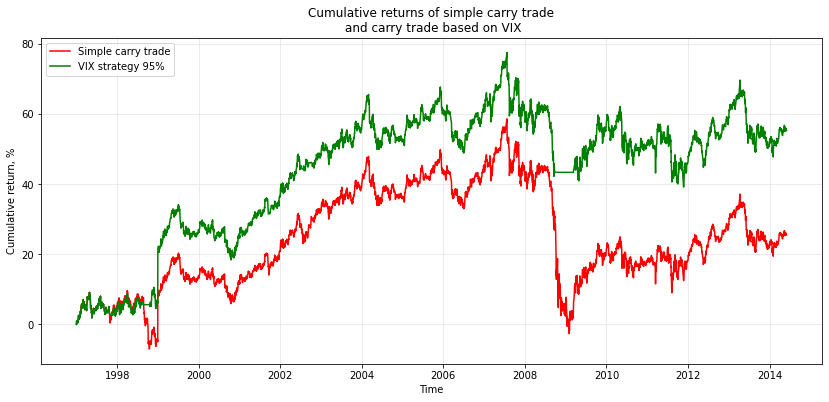

In [ ]:
carry_cumrets = (VixCarry.carry_returns + 1).cumprod() * 100 - 100
strategy_cumrets = (VixCarry.strategy_returns + 1).cumprod() * 100 - 100

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(carry_cumrets.index, carry_cumrets, 
        label='Simple carry trade', color='red')
ax.plot(strategy_cumrets.index, strategy_cumrets, 
        label='VIX strategy 95%', color='green')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative return, %')
ax.set_title('Cumulative returns of simple carry trade\n and carry trade based on VIX')
ax.legend(loc='upper left')
ax.grid(color='0.9')
fig.show();

И еще, мне кажется что после 2008 года обе стратегии особо денег не приносят.

Задачи.
1. Оформить `CarryTrade` в духе ООП:
  * написать `__init__`
  * Добавить метод для подсчета метрик (итоговая доходность, Шарп, аннуализированная доходность, аннуализированная волатильность, потом еще что-то докинем).
  * вынести расчет хотя бы части волатильности в отдельную функцию или метод (можно staticmethod, можно просто метод).
2. Написать обертку для параллельной обработки для разных перцентилей, параллельно оценить стратегии на сетке перцентилей. Можно прописать передачу параметров значений через кварги, сгенерировав кортеж из словарей.

Теперь оценим стратегии с помощью индексов волатильности $VIX_{t-1}$,  $VXY_{t-1}$ для набора различных перцентилей исторического распределения индекса волатильности. Для каждой из стратегий сохраним метрики, сравним аннуализированную доходность простого кэрри трейда с доходностью стратегий, учитывающих уровень индекса волатильности.

In [ ]:
# generate 50 quantiles: 50%, 51%, ...., 99%, 100%
quantiles = [x/100 for x in range(50,101)]

Напишем функцию, чтобы можно было оценить сразу много стратегий на для различных выборочных перцентилей индекса волатильности.

In [ ]:
def percentile_grid(percentiles:Union[np.array, list], 
                    fx:pd.DataFrame,
                    vol:pd.Series,
                    carry_kwargs:dict) -> pd.DataFrame:
    """
    Runs carry trade strategy with volatility indicator
    for different volitaility index percentiles
    """
    vix_metrics = {}
    Carry = CarryTrade(fx=fx, vol=vol)
    for i in range(len(percentiles)):
        p = percentiles[i]
        if i == 0:
            Carry.run(**carry_kwargs, vol_quantile=p)
        else:
            Carry.run(**carry_kwargs, vol_quantile=p, refit=False)
        vix_metrics[p] = Carry.perf_metrics()
        
    vix_df = pd.DataFrame(vix_metrics).T
    return vix_df

Стратегии с помощью $VIX_{t-1}$:

In [ ]:
%%time
# зададим параметры, общие для всех стратегий с разным перцентилем, в виде словаря
# зададим значения для всех параметров, кроме перцентиля индекса волатильности - он
# будет передаваться в виде списка перцентилей, рассматриваемых нами
# и передадим этот словарь в качестве аргумента функции percentile_grid
params = {'use_vol':True, 
          'vol_type':'simple',
          'quantile_method':'nearest',
          'vol_lag':1}

vix_df = percentile_grid(percentiles=quantiles, 
                         fx=fx.copy(), 
                         vol=vol.VIX.copy(), 
                         carry_kwargs=params)

CPU times: user 51.3 s, sys: 0 ns, total: 51.3 s
Wall time: 51.3 s


In [ ]:
vix_df.head(5)

,Carry trade total return,Strategy total return,Carry trade annualized total return,Strategy annualized total return,Carry trade Sharpe ratio,Strategy Sharpe ratio
0.50,0.255076,0.044376,0.017532,0.003310,0.011086,0.004888
0.51,0.255076,0.054844,0.017532,0.003876,0.011086,0.005674
0.52,0.255076,0.069344,0.017532,0.004647,0.011086,0.006741
0.53,0.255076,0.073771,0.017532,0.004913,0.011086,0.006990
0.54,0.255076,0.102445,0.017532,0.006385,0.011086,0.009013


Стратегии с помощью $VIX_{t-2}$ и $VIX_{t}$:

In [ ]:
%%time
# скопируем параметры и поменяем лаг, чтобы прогнать стратегии с лагом 0 и 2
params_l2 = params.copy()
params_l0 = params.copy()
params_l2['vol_lag'] = 2
params_l0['vol_lag'] = 0

# теперь оценим стратегии на разных значениях перцентилей
vix_df_l2 = percentile_grid(percentiles=quantiles, fx=fx.copy(), vol=vol.VIX.copy(), carry_kwargs=params_l2)
vix_df_l0 = percentile_grid(percentiles=quantiles, fx=fx.copy(), vol=vol.VIX.copy(), carry_kwargs=params_l0)

CPU times: user 1min 40s, sys: 0 ns, total: 1min 40s
Wall time: 1min 40s


Стратегии с помощью $VXY_{t-2},\ VXY_{t-1},\ VXY_{t}$:

In [ ]:
%%time
# скопируем параметры и поменяем лаг, чтобы прогнать стратегии с лагом 0 и 2
# наверно можно этого и делать - по идее, у нас уже и так заданы верные параметры
# но на всякий случай я создам параметры еще раз
params_l0 = params.copy()
params_l1 = params.copy()
params_l2 = params.copy()

params_l0['vol_lag'] = 0
params_l1['vol_lag'] = 1
params_l2['vol_lag'] = 2

# теперь оценим стратегии на разных значениях перцентилей
vxy_df_l0 = percentile_grid(percentiles=quantiles, fx=fx.copy(), vol=vol.VXY.copy(), carry_kwargs=params_l0)
vxy_df_l1 = percentile_grid(percentiles=quantiles, fx=fx.copy(), vol=vol.VXY.copy(), carry_kwargs=params_l1)
vxy_df_l2 = percentile_grid(percentiles=quantiles, fx=fx.copy(), vol=vol.VXY.copy(), carry_kwargs=params_l2)

CPU times: user 2min 14s, sys: 18.6 ms, total: 2min 14s
Wall time: 2min 14s


Теперь попробуем воспроизвести графики для доходности и Sharpe Ratio (4 штуки), которые мы видели в статье (**Figure 2**).

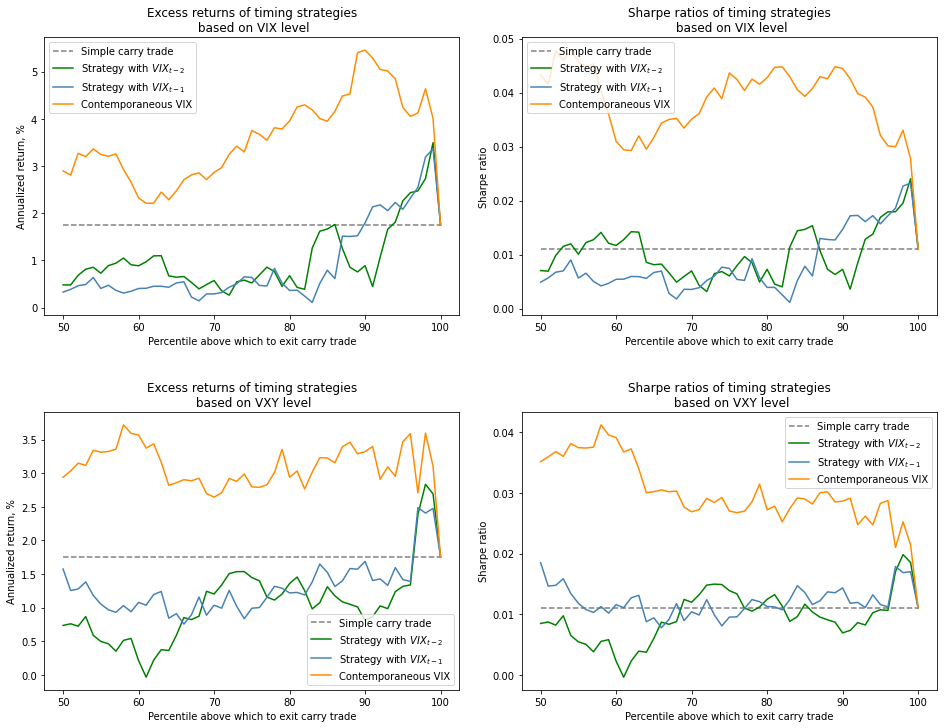

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12),
                       gridspec_kw={
                            'width_ratios': [3, 3],
                            'height_ratios': [3, 3],
                        'wspace': 0.15,
                        'hspace': 0.35})

ax[0, 0].plot(vix_df.index*100, vix_df['Carry trade annualized total return']*100,
              color='grey', label='Simple carry trade', linestyle='dashed')
ax[0, 0].plot(vix_df_l2.index*100, vix_df_l2['Strategy annualized total return']*100,
              color='green', label='Strategy with $VIX_{t-2}$')
ax[0, 0].plot(vix_df.index*100, vix_df['Strategy annualized total return']*100,
              color='steelblue', label='Strategy with $VIX_{t-1}$')
ax[0, 0].plot(vix_df_l0.index*100, vix_df_l0['Strategy annualized total return']*100,
              color='darkorange', label='Contemporaneous VIX')
ax[0, 0].set_xlabel('Percentile above which to exit carry trade')
ax[0, 0].set_ylabel('Annualized return, %')
ax[0, 0].set_title('Excess returns of timing strategies\n based on VIX level')
ax[0, 0].legend()

ax[1, 0].plot(vxy_df_l1.index*100, vxy_df_l1['Carry trade annualized total return']*100,
             color='grey', label='Simple carry trade', linestyle='dashed')
ax[1, 0].plot(vxy_df_l2.index*100, vxy_df_l2['Strategy annualized total return']*100,
             color='green', label='Strategy with $VIX_{t-2}$')
ax[1, 0].plot(vxy_df_l1.index*100, vxy_df_l1['Strategy annualized total return']*100,
             color='steelblue', label='Strategy with $VIX_{t-1}$')
ax[1, 0].plot(vxy_df_l0.index*100, vxy_df_l0['Strategy annualized total return']*100,
             color='darkorange', label='Contemporaneous VIX')
ax[1, 0].set_xlabel('Percentile above which to exit carry trade')
ax[1, 0].set_ylabel('Annualized return, %')
ax[1, 0].set_title('Excess returns of timing strategies\n based on VXY level')
ax[1, 0].legend()
fig.show();

ax[0, 1].plot(vix_df.index*100, vix_df['Carry trade Sharpe ratio'],
              color='grey', label='Simple carry trade', linestyle='dashed')
ax[0, 1].plot(vix_df_l2.index*100, vix_df_l2['Strategy Sharpe ratio'],
              color='green', label='Strategy with $VIX_{t-2}$')
ax[0, 1].plot(vix_df.index*100, vix_df['Strategy Sharpe ratio'],
              color='steelblue', label='Strategy with $VIX_{t-1}$')
ax[0, 1].plot(vix_df_l0.index*100, vix_df_l0['Strategy Sharpe ratio'],
              color='darkorange', label='Contemporaneous VIX')
ax[0, 1].set_xlabel('Percentile above which to exit carry trade')
ax[0, 1].set_ylabel('Sharpe ratio')
ax[0, 1].set_title('Sharpe ratios of timing strategies\n based on VIX level')
ax[0, 1].legend(loc='upper left')

ax[1, 1].plot(vxy_df_l1.index*100, vxy_df_l1['Carry trade Sharpe ratio'],
              color='grey', label='Simple carry trade', linestyle='dashed')
ax[1, 1].plot(vxy_df_l2.index*100, vxy_df_l2['Strategy Sharpe ratio'],
              color='green', label='Strategy with $VIX_{t-2}$')
ax[1, 1].plot(vxy_df_l1.index*100, vxy_df_l1['Strategy Sharpe ratio'],
              color='steelblue', label='Strategy with $VIX_{t-1}$')
ax[1, 1].plot(vxy_df_l0.index*100, vxy_df_l0['Strategy Sharpe ratio'],
              color='darkorange', label='Contemporaneous VIX')
ax[1, 1].set_xlabel('Percentile above which to exit carry trade')
ax[1, 1].set_ylabel('Sharpe ratio')
ax[1, 1].set_title('Sharpe ratios of timing strategies\n based on VXY level')
ax[1, 1].legend()
fig.show();